В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import log_evaluation

In [2]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
raw_df = pd.read_csv('train.csv')

In [4]:
target_col = 'Exited'
input_cols = raw_df.columns.drop(target_col)

In [5]:
train_df, val_df = split_train_val(raw_df, target_col)

In [6]:
# Для тренувальних даних
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)

# Для валідаційних даних
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [7]:
cat_features = train_inputs.select_dtypes(include='object').columns

train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category') 

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [8]:
params = {
    'max_depth': 3,  # Максимальна глибина дерева
    'eta': 0.1,  # Швидкість навчання
    'objective': 'binary:logistic',  # Для бінарної класифікації
    'eval_metric': 'auc',  # Використовуємо AUROC
    'missing': None  # XGBoost автоматично обробляє відсутні значення
}

In [9]:
dtrain = xgb.DMatrix(train_inputs, label=train_targets, enable_categorical=True)
dval = xgb.DMatrix(val_inputs, label=val_targets, enable_categorical=True)

In [10]:
num_round = 100  # Кількість ітерацій
watchlist = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(params, dtrain, num_round, evals=watchlist)

[0]	train-auc:0.89718	eval-auc:0.89115
[1]	train-auc:0.90134	eval-auc:0.89598
[2]	train-auc:0.90277	eval-auc:0.89705
[3]	train-auc:0.90699	eval-auc:0.89620
[4]	train-auc:0.90919	eval-auc:0.89997
[5]	train-auc:0.91415	eval-auc:0.90258
[6]	train-auc:0.91669	eval-auc:0.90976
[7]	train-auc:0.91750	eval-auc:0.90882
[8]	train-auc:0.91895	eval-auc:0.91197
[9]	train-auc:0.91948	eval-auc:0.91129
[10]	train-auc:0.92231	eval-auc:0.91449
[11]	train-auc:0.92415	eval-auc:0.91589
[12]	train-auc:0.92511	eval-auc:0.91626
[13]	train-auc:0.92539	eval-auc:0.91506
[14]	train-auc:0.92742	eval-auc:0.91631
[15]	train-auc:0.92894	eval-auc:0.91805
[16]	train-auc:0.92996	eval-auc:0.92023
[17]	train-auc:0.93129	eval-auc:0.92017
[18]	train-auc:0.93173	eval-auc:0.92022
[19]	train-auc:0.93428	eval-auc:0.92350
[20]	train-auc:0.93596	eval-auc:0.92444
[21]	train-auc:0.93747	eval-auc:0.92459
[22]	train-auc:0.93783	eval-auc:0.92441
[23]	train-auc:0.93912	eval-auc:0.92506
[24]	train-auc:0.94007	eval-auc:0.92542
[25]	train

In [11]:
# Передбачення на тренувальних та валідаційних даних
train_preds = model.predict(dtrain)
val_preds = model.predict(dval)

# Розрахунок AUROC
train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUC: {train_auc}")
print(f"Val AUC: {val_auc}")

Train AUC: 0.96170402126146
Val AUC: 0.9328722820495233


Модель значно покращилась порівняно з попередніми рішеннями. Пере- або недонавчання не спостерігається, маємо близькі по значенню AUROC на трейні і валідації

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [12]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict(val_inputs)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(train_inputs, train_targets)
final_pred = final_clf.predict(val_inputs)
final_accuracy = accuracy_score(val_targets, final_pred)
print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|██▍                                             | 1/20 [00:00<00:06,  2.88trial/s, best loss: -0.8936666666666667]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|████▊                                           | 2/20 [00:01<00:09,  1.82trial/s, best loss: -0.8946666666666667]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|███████▏                                        | 3/20 [00:01<00:07,  2.37trial/s, best loss: -0.8956666666666667]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|█████████▌                                      | 4/20 [00:01<00:06,  2.29trial/s, best loss: -0.8976666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|████████████                                    | 5/20 [00:02<00:05,  2.61trial/s, best loss: -0.8976666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|██████████████▍                                 | 6/20 [00:03<00:08,  1.61trial/s, best loss: -0.8976666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|████████████████▊                               | 7/20 [00:04<00:11,  1.11trial/s, best loss: -0.8976666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|███████████████████▏                            | 8/20 [00:05<00:12,  1.05s/trial, best loss: -0.8976666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|███████████████████████████▍                                 | 9/20 [00:07<00:11,  1.09s/trial, best loss: -0.898]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|██████████████████████████████                              | 10/20 [00:07<00:08,  1.19trial/s, best loss: -0.898]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████████████████████████████████                           | 11/20 [00:07<00:06,  1.35trial/s, best loss: -0.898]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|████████████████████████████▏                  | 12/20 [00:08<00:05,  1.49trial/s, best loss: -0.8996666666666666]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|███████████████████████████████████████                     | 13/20 [00:08<00:04,  1.73trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|██████████████████████████████████████████                  | 14/20 [00:09<00:03,  1.87trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|█████████████████████████████████████████████               | 15/20 [00:09<00:02,  1.72trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████████████████████████████████████████████            | 16/20 [00:10<00:02,  1.71trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|███████████████████████████████████████████████████         | 17/20 [00:10<00:01,  1.97trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|██████████████████████████████████████████████████████      | 18/20 [00:11<00:00,  2.19trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████████████████████████████████████████████████████   | 19/20 [00:12<00:00,  1.74trial/s, best loss: -0.901]

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61trial/s, best loss: -0.901]
Найкращі гіперпараметри:  {'colsample_bytree': 0.6057124746343694, 'gamma': 0.07239478252026871, 'learning_rate': 0.12650003756514877, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 350, 'reg_alpha': 0.09130460865733458, 'reg_lambda': 0.1864183309890357, 'subsample': 0.6724589791149256}


c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Точність на валідаційній вибірці: 0.8903


Порівняно із завданням 2 дана модель спрацювала гірше

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [13]:
# Визначення індексів категоріальних ознак
cat_features = [i for i, t in enumerate(train_inputs.dtypes) if t == 'object' or t == 'category']

In [14]:
# Налаштування параметрів
params = {
    'objective': 'binary',  # Для бінарної класифікації
    'metric': 'auc',  # Оцінюємо за AUC-ROC
    'verbosity': -1,  # Вимкнути виведення інформації
    'num_leaves': 31,  # Максимальна кількість листів в дереві
    'learning_rate': 0.1,  # Швидкість навчання
    'feature_fraction': 0.9,  # Частка ознак, що використовуються для кожного дерева
    'bagging_fraction': 0.8,  # Частка спостережень, що використовуються для кожного дерева
    # LightGBM автоматично обробляє відсутні значення та категоріальні ознаки
}

# Перетворення даних в формат LightGBM
train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_features)
val_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_features)

# Навчання моделі
gbm = lgb.train(params,
                train_data,
                num_boost_round=100,
                valid_sets=[train_data, val_data],
                callbacks=[log_evaluation(period=10)])

[10]	training's auc: 0.943191	valid_1's auc: 0.932983
[20]	training's auc: 0.954158	valid_1's auc: 0.93315
[30]	training's auc: 0.964255	valid_1's auc: 0.934412
[40]	training's auc: 0.971325	valid_1's auc: 0.935238
[50]	training's auc: 0.977523	valid_1's auc: 0.934235
[60]	training's auc: 0.981673	valid_1's auc: 0.933268
[70]	training's auc: 0.985126	valid_1's auc: 0.932447
[80]	training's auc: 0.987917	valid_1's auc: 0.931197
[90]	training's auc: 0.990171	valid_1's auc: 0.93103
[100]	training's auc: 0.992002	valid_1's auc: 0.930693


In [15]:
# Прогнози на тренувальному та валідаційному наборах
y_train_pred = gbm.predict(train_inputs)
y_val_pred = gbm.predict(val_inputs)

# Розрахунок AUC-ROC
train_auc = roc_auc_score(train_targets, y_train_pred)
val_auc = roc_auc_score(val_targets, y_val_pred)

print('Train AUC:', train_auc)
print('Val AUC:', val_auc)

Train AUC: 0.9920021888006822
Val AUC: 0.9306927772823924


Маємо значно кращі результати роботи моделі. **На даний момент це найкращий результат**

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [16]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_features  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict(val_inputs)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_features,
    missing=np.nan
)

final_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
final_pred = final_clf.predict(val_inputs)
final_accuracy = accuracy_score(val_targets, final_pred)

print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))


100%|███████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/trial, best loss: -0.8943333333333333]
Найкращі гіперпараметри:  {'colsample_bytree': 0.7123387514249047, 'learning_rate': 0.037479247574000916, 'max_depth': 12, 'min_child_weight': 4, 'min_split_gain': 0.09355271846666924, 'n_estimators': 150, 'num_leaves': 130, 'reg_alpha': 0.1454515838586502, 'reg_lambda': 0.4193471648161927, 'subsample': 0.9011648616364027}
Точність на валідаційній вибірці: 0.8943


На даному експерименті ми отримали гірші результати, ніж експерименти раніше

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

Найкращий результат ми отримали в експерименті 4 з моделлю LightGBM. Саме цей результат ми і засабмішимо у змаганні.

In [17]:
test_inputs = pd.read_csv('test.csv')

cat_features = test_inputs.select_dtypes(include='object').columns
test_inputs[cat_features] = test_inputs[cat_features].astype('category')

y_test_pred = gbm.predict(test_inputs)

In [18]:
# Перетворюємо масив в Series
test_preds_df = pd.DataFrame()
test_preds_df = test_preds_df.assign(Exited=y_test_pred)

# Об'єднуємо DataFrame и Series
Final = pd.concat([test_inputs, test_preds_df], axis=1)

#залишаємо для завантаження на Kaggle лише CustomerId і Exited
Final = Final[['id', 'Exited']]

In [19]:
Final.to_csv('submission .csv', index=False)

Мій Score на Leaderbord :-)


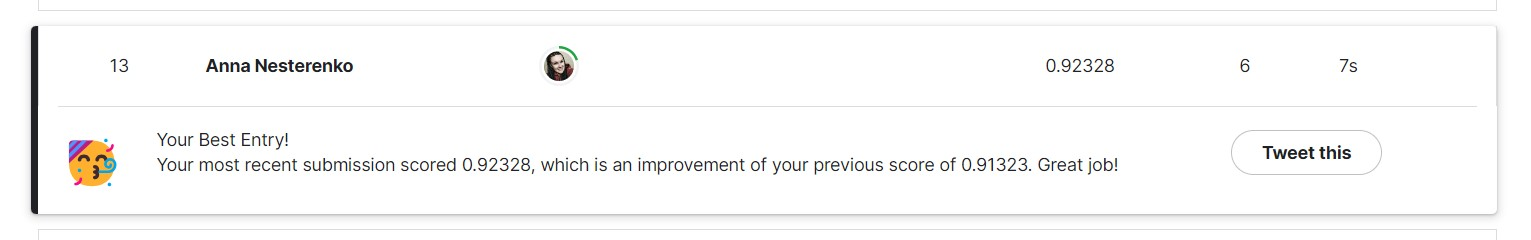

In [20]:
from IPython.display import Image
print('Мій Score на Leaderbord :-)')
Image("Screenshot_3.jpg", width=1320, height=1240) 